In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. Load Data
df = pd.read_csv('../data/processed/market_features.csv', index_col=0, parse_dates=True)

# 2. Create the Target (The "Truth")
# We want to predict if returns will be < -1% TOMORROW
# shift(-1) moves tomorrow's data to today's row.
df['Next_Day_Return'] = df['SPY_Log_Ret'].shift(-1)

# Define "Crash": A drop of more than 1% (approx -0.01 log return)
THRESHOLD = -0.01
df['Target'] = (df['Next_Day_Return'] < THRESHOLD).astype(int)

# Drop the NaN created by shifting (the last day has no "tomorrow")
df = df.dropna()

# 3. Sanity Check: How balanced is our data?
print("Target Distribution:")
print(df['Target'].value_counts(normalize=True))
# You will likely see ~85% '0' (Safe) and ~15% '1' (Crash)

Target Distribution:
Target
0    0.849372
1    0.150628
Name: proportion, dtype: float64


In [2]:
# 1. Define Features (X) and Target (y)
# We use Volatility and Returns to predict the future
features = ['SPY_Log_Ret', 'SPY_Vol_30d'] # We will add more in Week 12
X = df[features]
y = df['Target']

# 2. Time-Series Split
# First 80% of days for training, last 20% for testing
train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")

Training Samples: 764
Testing Samples: 192


In [3]:
# 1. Initialize Model
# class_weight='balanced': This tells the model to pay 
# more attention to the rare "Crash" events. Crucial!
log_model = LogisticRegression(class_weight='balanced')

# 2. Train
log_model.fit(X_train, y_train)

# 3. Predict (Probabilities and Classes)
y_pred_prob = log_model.predict_proba(X_test)[:, 1] # Probability of Class 1
y_pred = log_model.predict(X_test) # Hard prediction (0 or 1)

# 4. Evaluate
print("--- Logistic Regression Results ---")
print(classification_report(y_test, y_pred))

--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       177
           1       0.00      0.00      0.00        15

    accuracy                           0.92       192
   macro avg       0.46      0.50      0.48       192
weighted avg       0.85      0.92      0.88       192



/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/avniderashree/miniconda3/envs/quant_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [4]:
# 1. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 2. Predict
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]

print("--- Random Forest Results ---")
print(classification_report(y_test, rf_pred))

--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       177
           1       0.00      0.00      0.00        15

    accuracy                           0.84       192
   macro avg       0.46      0.46      0.46       192
weighted avg       0.84      0.84      0.84       192



Logistic ROC-AUC: 0.4000
Random Forest ROC-AUC: 0.4731


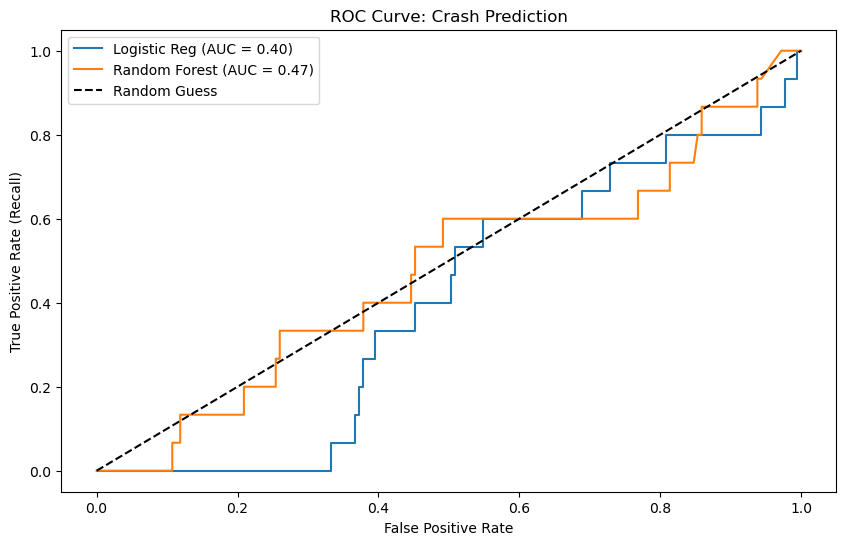

In [5]:
# Calculate ROC Scores
log_roc = roc_auc_score(y_test, y_pred_prob)
rf_roc = roc_auc_score(y_test, rf_prob)

print(f"Logistic ROC-AUC: {log_roc:.4f}")
print(f"Random Forest ROC-AUC: {rf_roc:.4f}")

# Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Reg (AUC = {log_roc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve: Crash Prediction')
plt.legend()
plt.show()